<a href="https://colab.research.google.com/github/zahmeeth/Comprehensive_Dissertation_UNL_CSE2019_Templates/blob/master/2022_10_07_Zahmeeth_Sakkaff_Session3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Home Work Session 3: Neural Networks in Tensorflow (10/07/22) by Zahmeeth Sakkaff

CIFAR-10 dataset classification with CNNs

Homework: improve the accuracy of this model

I have changed the optimizer from sgd to adamax, lowering the batch_size 64, increasing the epochs 6 and correct lr would improve accuracy of the model where it increased from 58.69% to 66.25% with trial an error or all combination of these parameters can improve the accuracy

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

CIFAR-10 data set

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

170508288/170498071 [==============================] - 2s 0us/step


Convolutional neural network (CNN)

In [6]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

Simple training

In [8]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adamax", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [10]:
# This took 43 seconds per epoch on my laptop
batch_size = 64
epochs = 6
lr = .05
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/6
782/782 [==============================] - 169s 215ms/step - loss: 1.6876 - accuracy: 0.3914
Epoch 2/6
782/782 [==============================] - 169s 216ms/step - loss: 1.3833 - accuracy: 0.5045
Epoch 3/6
782/782 [==============================] - 168s 215ms/step - loss: 1.2612 - accuracy: 0.5558
Epoch 4/6
782/782 [==============================] - 168s 215ms/step - loss: 1.1715 - accuracy: 0.5869
Epoch 5/6
782/782 [==============================] - 170s 217ms/step - loss: 1.0979 - accuracy: 0.6127
Epoch 6/6
782/782 [==============================] - 168s 215ms/step - loss: 1.0433 - accuracy: 0.6338


Accuracy for test data. The model should be better than the non-convolutional model even if you're only patient enough for three epochs.

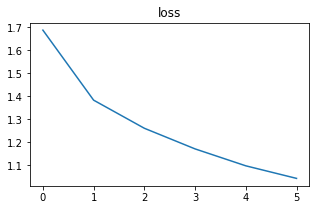

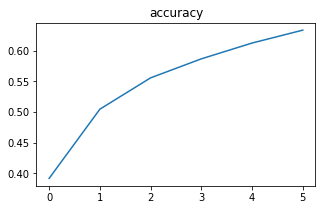

In [11]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

Inference

With enough training epochs, the test accuracy should exceed 96.53%.
You can compare your result with the state-of-the art here.

In [12]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 14s - loss: 0.9610 - accuracy: 0.6625 - 14s/epoch - 45ms/step
accuracy: 66.25%
CPU times: user 15.5 s, sys: 186 ms, total: 15.7 s
Wall time: 15.4 s


We can also again check the confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[684  16  85  22  21   4  18   9  97  44]
 [ 25 732  11  11   4   3  19   8  42 145]
 [ 61   4 558  54  88  82  93  32  12  16]
 [ 18   8 101 421  76 166 130  42  15  23]
 [ 28   2 119  53 581  23  86  90  15   3]
 [ 10   2 106 166  49 560  38  56   6   7]
 [  4   3  56  41  42  16 821   8   3   6]
 [ 16   2  48  40  67  69   8 732   1  17]
 [ 78  56  17  11   6  10  16   2 764  40]
 [ 38  77  11  12  10   7  13  24  36 772]]

Classification accuracy for each class:

0: 0.6840
1: 0.7320
2: 0.5580
3: 0.4210
4: 0.5810
5: 0.5600
6: 0.8210
7: 0.7320
8: 0.7640
9: 0.7720


More verbose training
This approach explicitly handles the looping over data. It will be helpful in future weeks for diving in and optimizing

In [14]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [15]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [16]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [17]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 64
epochs = 6
lr = .05
train_network(batch_size, epochs, lr)

beginning epoch 0
took 161.6 seconds for epoch #0
beginning epoch 1
took 169.7 seconds for epoch #1
beginning epoch 2
took 153.8 seconds for epoch #2
beginning epoch 3
took 156.9 seconds for epoch #3
beginning epoch 4
